In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

from matplotlib import pyplot as plt
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

plt.rcParams["font.sans-serif"] = ["Times New Roman"]
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import enet_path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import plot_roc_curve
from sklearn.inspection import plot_partial_dependence
import xgboost
# import shap
from sklearn.metrics import *

In [2]:
datainfer=pd.read_csv("datainfer.csv").iloc[:,1:]
datainfer_test=pd.read_csv("datainfer_test.csv").iloc[:,1:]

In [3]:
col=['1 Try', '2 Tries', '3 Tries', '4 Tries','5 Tries', '6 Tries',"Above 6 Tries"]
def predictdata(name,datainfer):
    coltemp=['1 Try', '2 Tries', '3 Tries', '4 Tries','5 Tries', '6 Tries',"Above 6 Tries"]
    coltemp.remove(name)
    data=datainfer.drop(columns=coltemp)
    return data

In [4]:
choose=["reast reductions","crane score","crate reductions","slate score","salet score","RepeatN","slate Attitude","trace Description","crane Topics","WordCharacter"]
yall=[]
Xall=[]
ytestall=[]
Xtestall=[]
for name in col:
    data1=predictdata(name,datainfer)
    y=data1[name]
    X=data1.drop(columns=[name])
    yall.append(y)
    Xall.append(X)
    datatest=predictdata(name,datainfer_test)
    ytest=datatest[name]
    Xtest=datatest.drop(columns=[name])
    ytestall.append(ytest)
    Xtestall.append(Xtest)

In [5]:
def vmcal(X,y):
    from tqdm import tqdm
    ## 使用参数网格搜索的方法寻找最合适的threshold 和 ranching_factor参数
    n_estimators = np.arange(1, 150)
    max_depth = np.arange(1, 15)
    threx, ranchy = np.meshgrid(n_estimators, max_depth)
    vm = np.ones_like(threx, dtype=float)
    ## 计算不同参数组合下的V测度
    for i, t in enumerate(tqdm(n_estimators)):
        for j, r in enumerate(max_depth):
            model = xgboost.XGBRFRegressor(random_state=831, subsample=0.81, n_estimators=t, max_depth=r, learning_rate=1,
                                           colsample_bytree=0.6, n_jobs=-1)
            model.fit(X, y)
        vm[j, i] = 1-mean_absolute_error(y,model.predict(X))
    return vm

In [57]:
# vmall=[]
# for i,j in enumerate(Xall):
#     vmall.append(vmcal(Xall[i],yall[i]))

100%|██████████| 149/149 [02:19<00:00,  1.06it/s]


In [6]:
import joblib
# joblib.dump(vmall, 'vmall.pkl')
vmall = joblib.load('vmall.pkl')

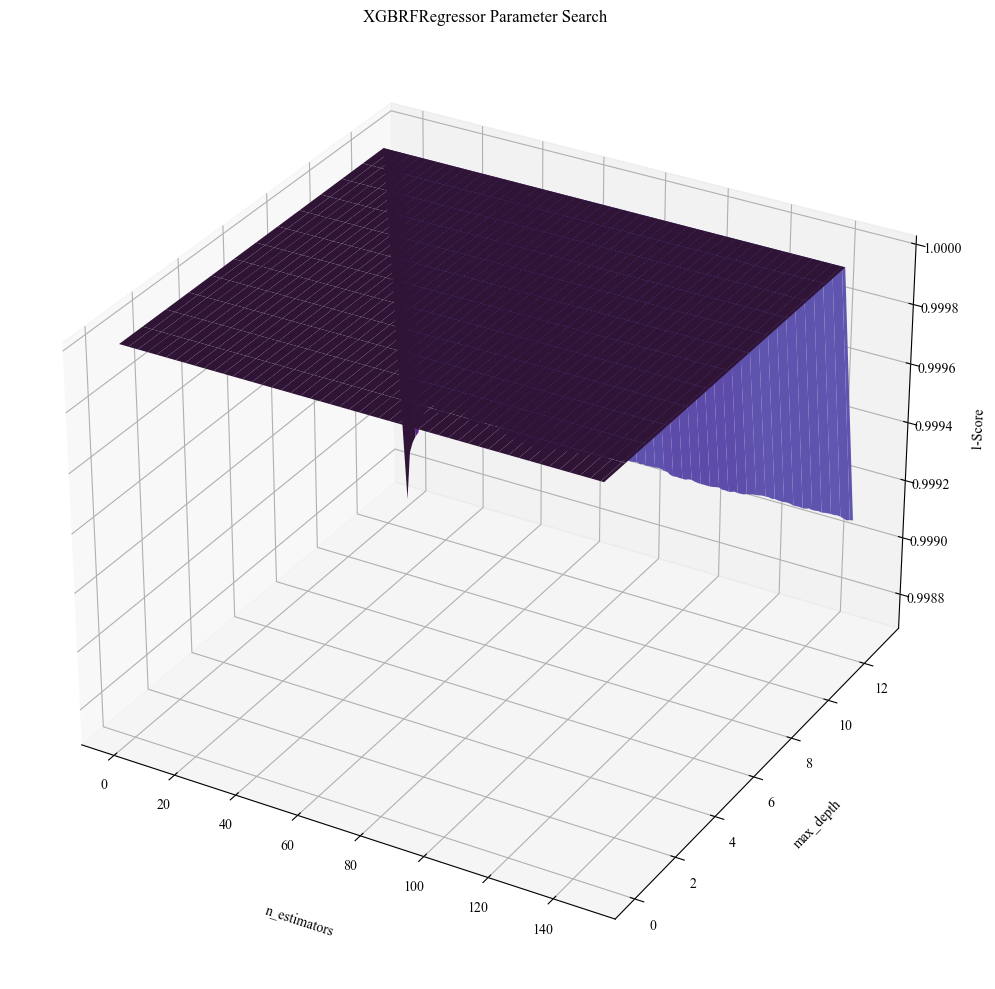

In [60]:
## 使用3D曲面图可视化交叉验证的平均均方根误差
n_estimators = np.arange(1, 150)
max_depth = np.arange(1, 15)
## 数据准备
i, j = np.meshgrid(range(len(n_estimators)), range(len(max_depth)))
## 可视化
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection="3d")
surf = ax1.plot_surface(i, j, vmall[0], cmap='twilight_shifted',
                        linewidth=0.1)
# plt.xticks(range(len(n_estimators)/4),n_estimators,rotation=45)
# plt.yticks(range(len(max_depth)),max_depth,rotation=125)
ax1.set_xlabel("n_estimators", labelpad=25)
ax1.set_ylabel("max_depth", labelpad=15)
ax1.set_zlabel("1-Score", rotation=90, labelpad=10)
plt.title("XGBRFRegressor Parameter Search")
plt.tight_layout()
plt.savefig("参数选择.pdf", dpi=5000)
plt.show()

In [131]:
param_distributions = {'n_estimators': range(1, 300), 'max_depth': range(1, 200),
                       'subsample': np.linspace(0.1,1,20), 'learning_rate': np.linspace(0.1, 1, 20),'colsample_bytree':np.linspace(0.1, 1, 10)}
kfold = KFold(n_splits=10, shuffle=True, random_state=831)
model = RandomizedSearchCV(estimator=xgboost.XGBRFRegressor(random_state=123),
                           param_distributions=param_distributions, cv=kfold, n_iter=5000, random_state=831,n_jobs=-1)
model.fit(np.array(X), np.array(y))
model.best_params_

{'subsample': 0.1473684210526316,
 'n_estimators': 197,
 'max_depth': 132,
 'learning_rate': 1.0,
 'colsample_bytree': 0.9}

In [44]:
model = xgboost.XGBRFRegressor(subsample=0.1473,n_estimators=197,max_depth=132,learning_rate=1,colsample_bytree=0.9,n_jobs=-1)
model.fit(X, y)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=0.9,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=132, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=197, n_jobs=-1, num_parallel_tree=197,
               objective='reg:squarederror', predictor='auto', random_state=0,
               reg_alpha=0, sampling_method='uniform', ...)

In [7]:
model.score(X,y)

0.32503887932819264

In [14]:
mean_absolute_error(ytest,model.predict(Xtest))
mean_squared_error(ytest,model.predict(Xtest))
mean_squared_log_error(ytest,model.predict(Xtest))

0.001576387525163887

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


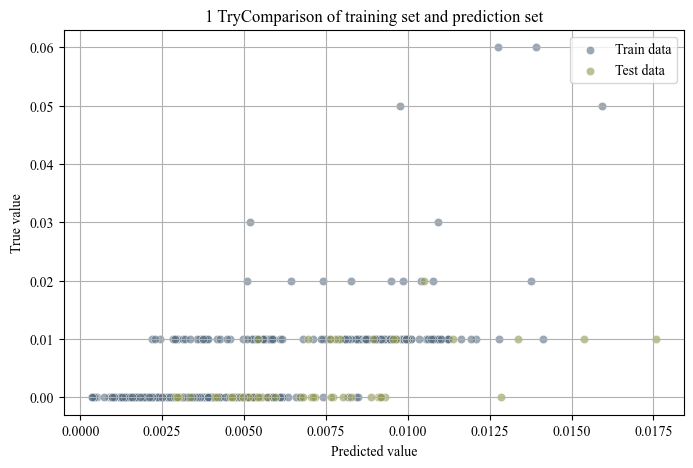

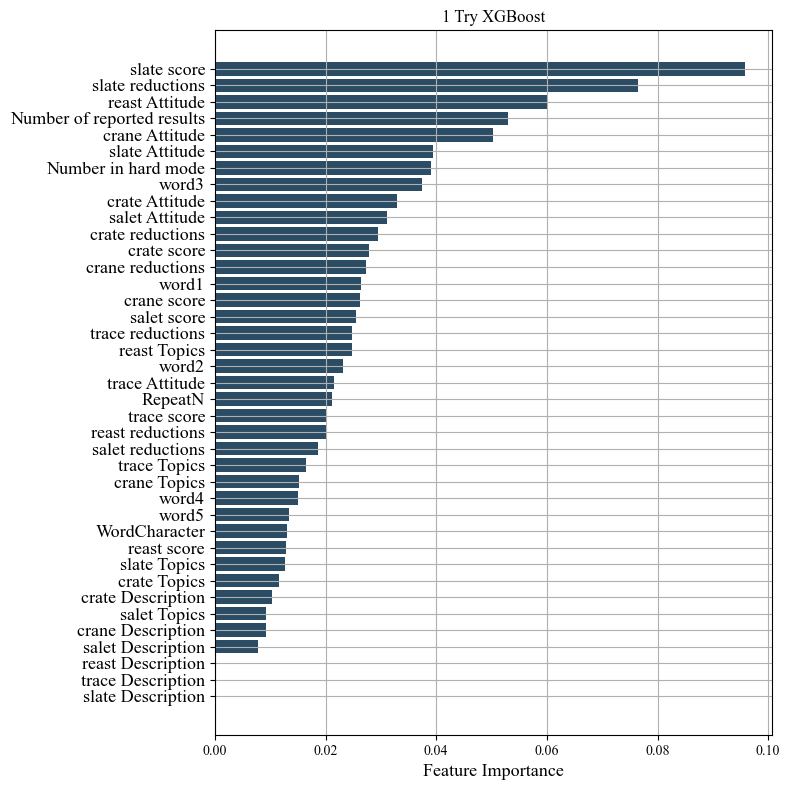

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


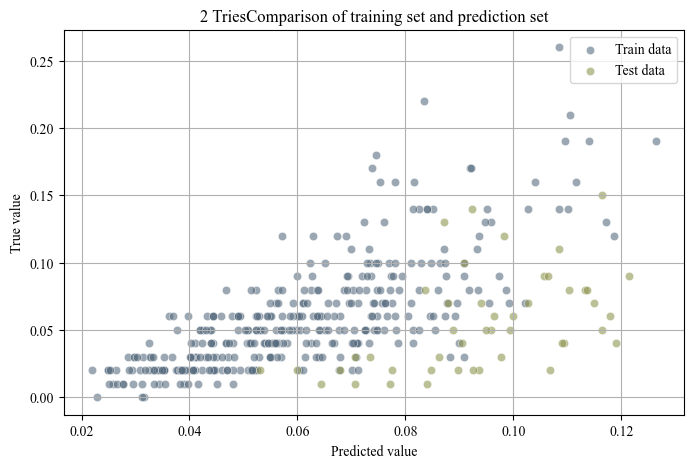

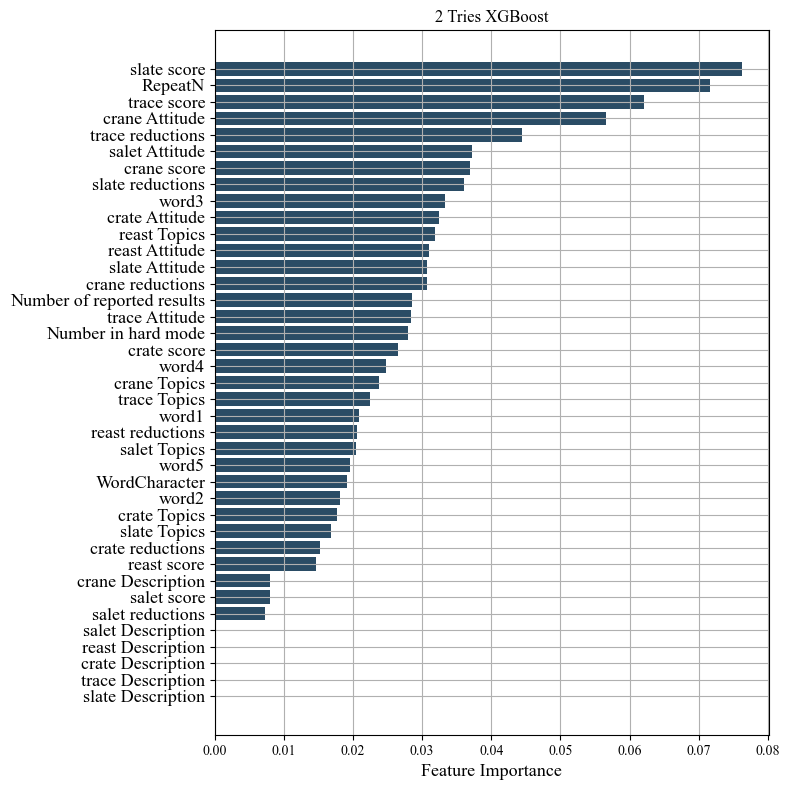

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


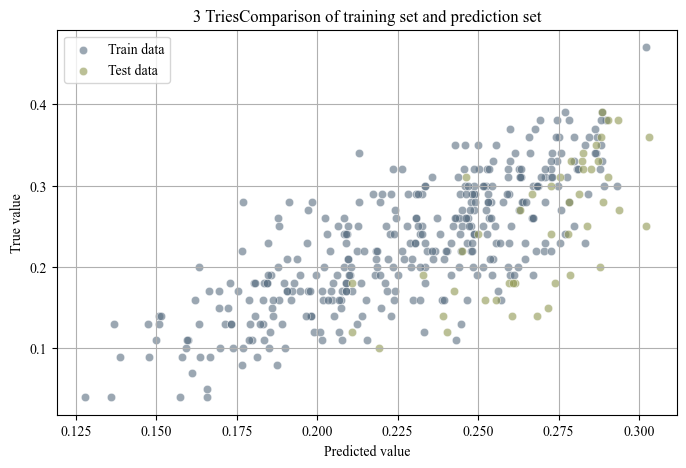

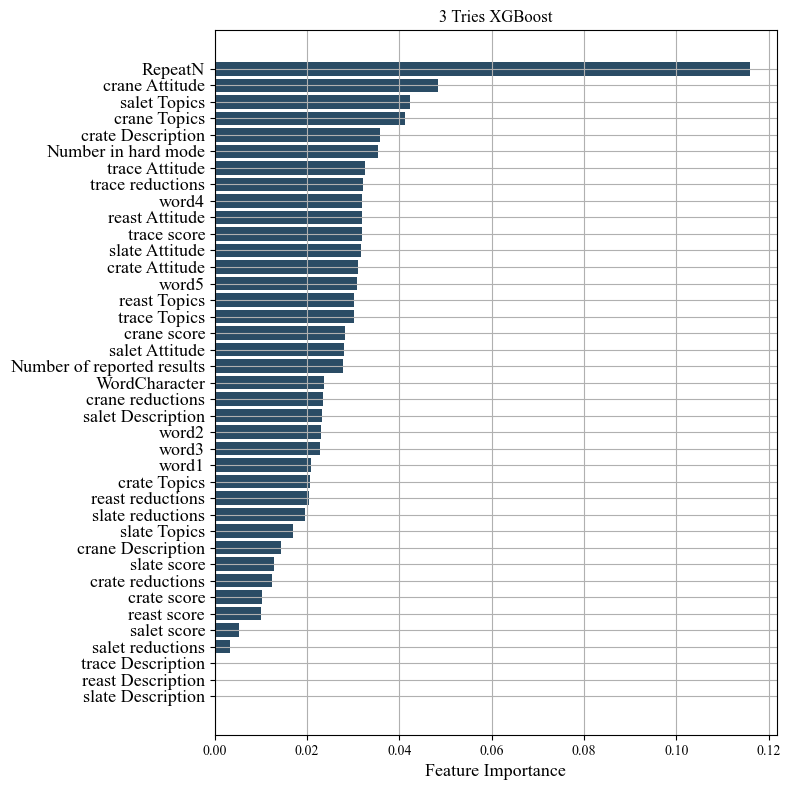

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


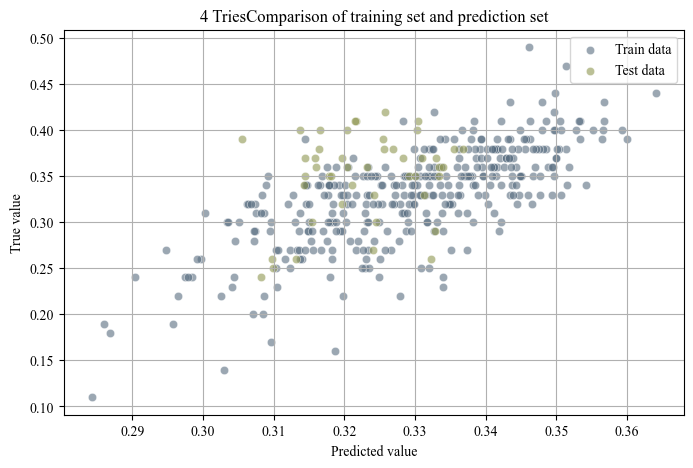

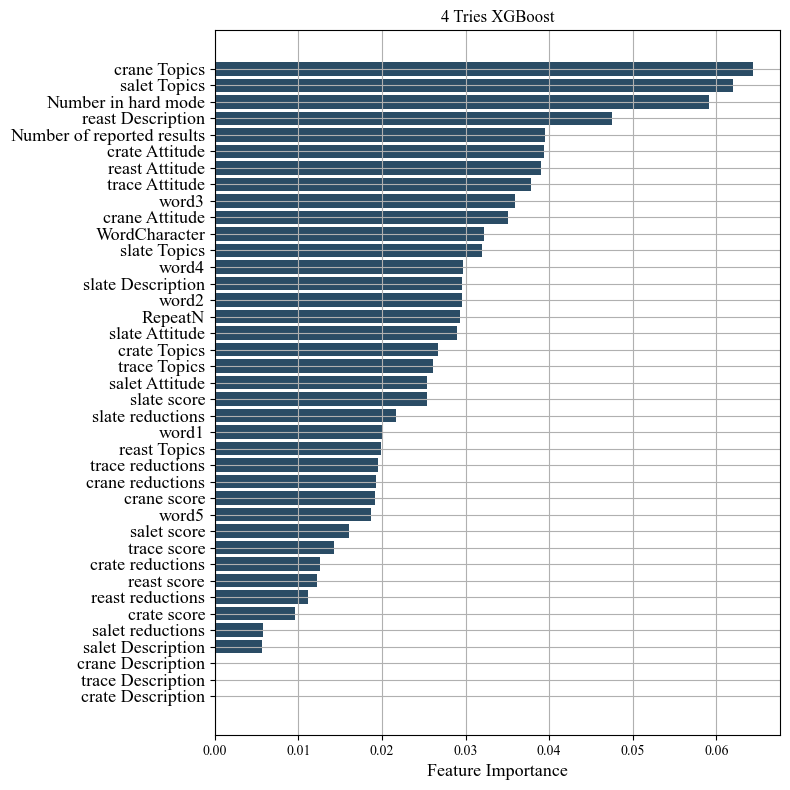

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


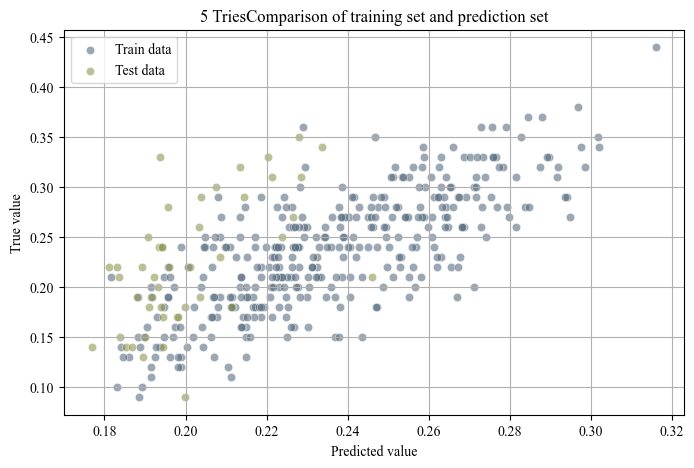

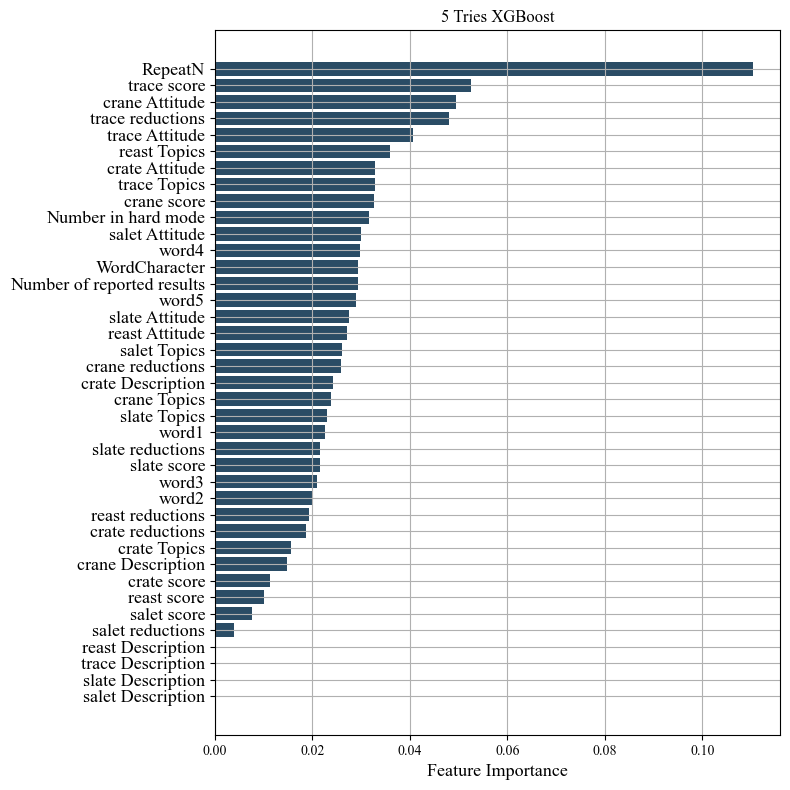

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


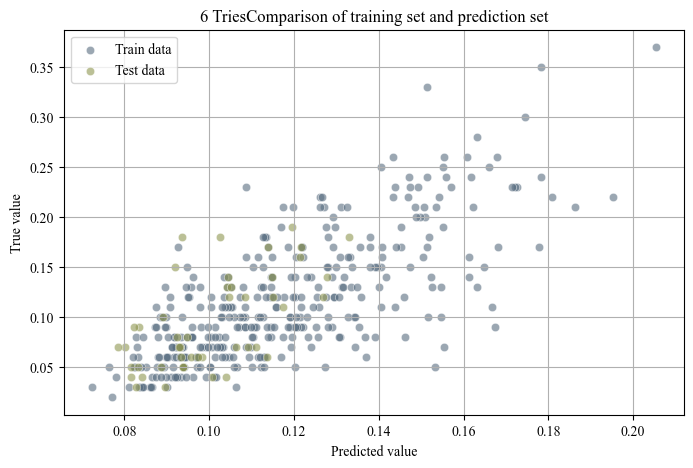

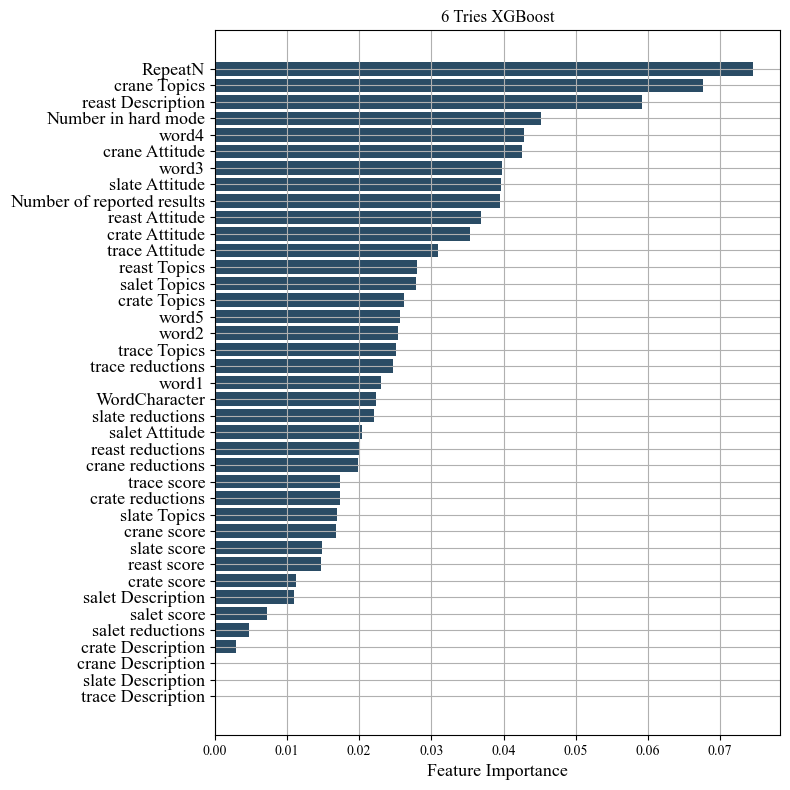

D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\ANA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


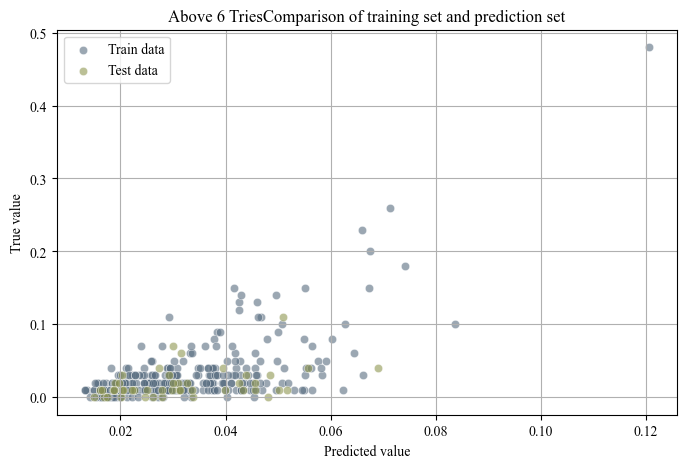

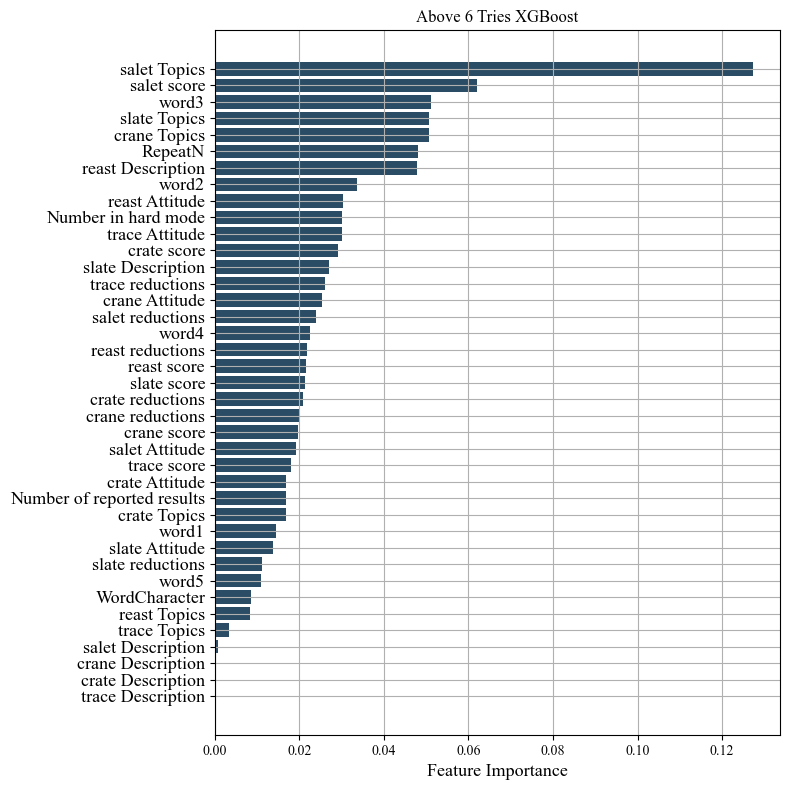

In [12]:
MAEall=[]
MSEall=[]
MAEtestall=[]
MSEtestall=[]
for i in range(7):
    model = xgboost.XGBRFRegressor(subsample=0.1473,n_estimators=197,max_depth=132,learning_rate=1,colsample_bytree=0.9,n_jobs=-1)
    model.fit(Xall[i], yall[i])
    plt.figure(figsize=(8,5))
    sns.scatterplot(model.predict(Xall[i]),yall[i],label="Train data",alpha=0.6,color="#586D80")
    sns.scatterplot(model.predict(Xtestall[i]),ytestall[i],label="Test data",alpha=0.6,color="#8F9650")
    MAEall.append(mean_absolute_error(yall[i],model.predict(Xall[i])))
    MSEall.append(mean_squared_error(yall[i],model.predict(Xall[i])))
    MAEtestall.append(mean_absolute_error(ytestall[i],model.predict(Xtestall[i])))
    MSEtestall.append(mean_squared_error(ytestall[i],model.predict(Xtestall[i])))
    plt.legend()
    plt.grid()
    plt.xlabel("Predicted value")
    plt.ylabel("True value")
    plt.title(col[i]+"Comparison of training set and prediction set")
    plt.savefig(col[i]+"Comparison of training set and prediction set.svg")
    plt.show()

        #要素权重
    plt.figure(figsize=(8,8))
    model.feature_importances_
    sorted_index = model.feature_importances_.argsort()
    plt.barh(range(X.shape[1]), model.feature_importances_[sorted_index],color="#2A4C65")
    plt.yticks(np.arange(X.shape[1]), X.columns[sorted_index],fontsize=13)
    plt.xlabel('Feature Importance',fontsize=13)
    plt.title(col[i]+' XGBoost')
    # ax.bar_label(ax.containers[0], labels=[f'{x.get_height():.3f}'+"("+str(format(P[o],'.3f'))+")" for o,x in enumerate(ax.containers[0])])
    plt.tight_layout()
    # plt.savefig("重要程度2.pdf")
    plt.grid()
    plt.savefig(col[i]+"权重.svg")
    plt.show()

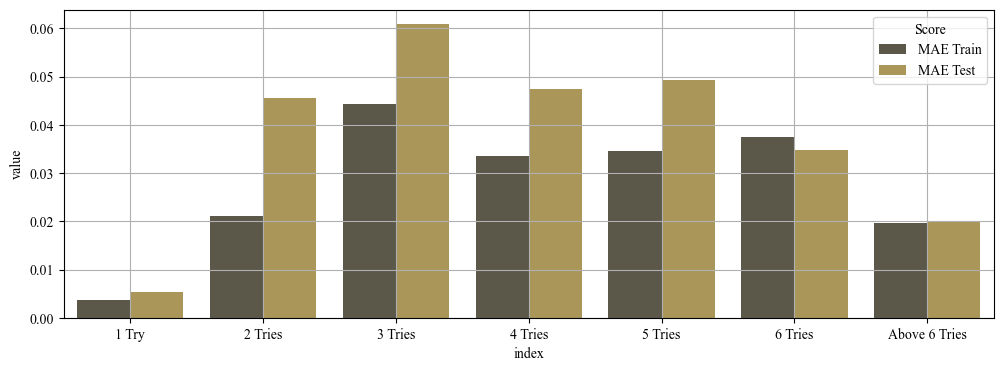

In [20]:
df4 = pd.DataFrame([MAEall,MSEall,MAEtestall,MSEtestall],columns=['1 Try', '2 Tries', '3 Tries', '4 Tries', '5 Tries', '6 Tries',
       'Above 6 Tries'])
df4 =df4.T
df4.columns=["MAE Train","MSE Train","MAE Test","MSE Test"]
df4=df4.reset_index()
df4long = df4.melt(value_vars = ["MAE Train","MAE Test"],
                   var_name="Score",value_name="value",id_vars=["index"])
plt.figure(figsize=(12,4))

sns.barplot(data=df4long,x="index", hue="Score",y="value",palette = ["#5E5946","#B69D4B","#2A86FF","#A4B7F0","#4B6DAB"])
plt.grid()
plt.savefig("准确度MAE.svg")
plt.show()

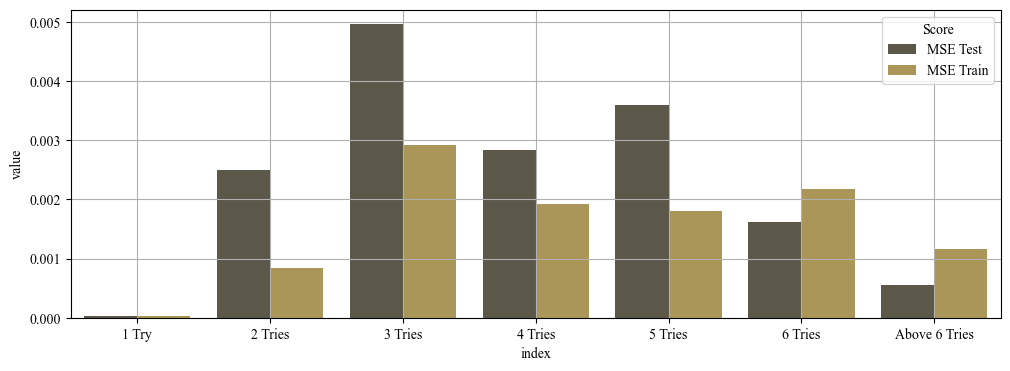

In [21]:
df4 = pd.DataFrame([MAEall,MSEall,MAEtestall,MSEtestall],columns=['1 Try', '2 Tries', '3 Tries', '4 Tries', '5 Tries', '6 Tries',
       'Above 6 Tries'])
df4 =df4.T
df4.columns=["MAE Train","MSE Train","MAE Test","MSE Test"]
df4=df4.reset_index()
df4long = df4.melt(value_vars = ["MSE Test","MSE Train"],
                   var_name="Score",value_name="value",id_vars=["index"])
plt.figure(figsize=(12,4))

sns.barplot(data=df4long,x="index", hue="Score",y="value",palette = ["#5E5946","#B69D4B","#2A86FF","#A4B7F0","#4B6DAB"])
plt.grid()
plt.savefig("准确度MSE.svg")
plt.show()

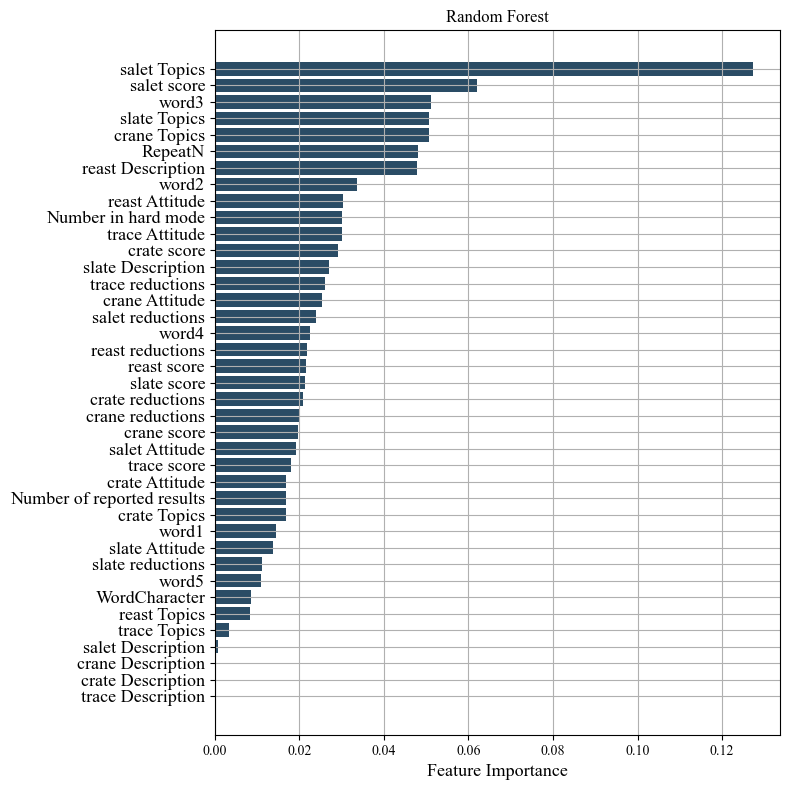

In [8]:
#要素权重
plt.figure(figsize=(8,8))
model.feature_importances_
sorted_index = model.feature_importances_.argsort()
plt.barh(range(X.shape[1]), model.feature_importances_[sorted_index],color="#2A4C65")
plt.yticks(np.arange(X.shape[1]), X.columns[sorted_index],fontsize=13)
plt.xlabel('Feature Importance',fontsize=13)
plt.title('Random Forest')
# ax.bar_label(ax.containers[0], labels=[f'{x.get_height():.3f}'+"("+str(format(P[o],'.3f'))+")" for o,x in enumerate(ax.containers[0])])
plt.tight_layout()
# plt.savefig("重要程度2.pdf")
plt.grid()
plt.show()

In [22]:
datainfer_test

,salet reductions,salet score,reast reductions,reast score,crate reductions,crate score,trace reductions,trace score,slate reductions,slate score,...,crane Attitude,Number of reported results,Number in hard mode,1 Try,2 Tries,3 Tries,4 Tries,5 Tries,6 Tries,Above 6 Tries
0,5,3,4,3,5,3,5,3,3,3,...,0.429970,22072,2132,0.00,0.04,0.27,0.41,0.22,0.06,0.01
1,1,2,1,2,3,3,3,3,1,2,...,0.458872,22252,2094,0.00,0.06,0.31,0.39,0.19,0.05,0.00
2,1,2,1,2,1,2,1,2,3,3,...,0.472512,22018,2072,0.00,0.07,0.32,0.37,0.18,0.05,0.00
3,1,2,2,2,2,2,2,2,1,2,...,0.461231,22394,2207,0.00,0.05,0.18,0.25,0.22,0.19,0.11
4,1,2,1,2,5,3,5,3,1,2,...,0.496679,22283,2078,0.00,0.03,0.22,0.42,0.25,0.07,0.01
5,1,2,5,3,4,2,4,2,1,2,...,0.458872,19725,1936,0.00,0.01,0.12,0.33,0.33,0.17,0.03
6,3,3,5,3,5,3,5,3,1,2,...,0.472185,21946,2072,0.01,0.08,0.29,0.37,0.19,0.06,0.01
7,4,3,3,3,3,3,3,3,1,2,...,0.528674,21510,2054,0.02,0.10,0.29,0.33,0.20,0.06,0.01
8,5,3,3,2,5,3,5,3,2,2,...,0.458872,20248,2049,0.00,0.02,0.12,0.30,0.34,0.18,0.04
9,5,3,5,3,1,2,1,2,5,3,...,0.453228,22248,2157,0.00,0.02,0.19,0.40,0.28,0.09,0.01


In [53]:
data2=pd.read_csv("datainfer_pre.csv").iloc[:,1:]
data2

,salet reductions,salet score,reast reductions,reast score,crate reductions,crate score,trace reductions,trace score,slate reductions,slate score,...,crane Attitude,Number of reported results,Number in hard mode,1 Try,2 Tries,3 Tries,4 Tries,5 Tries,6 Tries,Above 6 Tries
0,1,2,1,2,1,2,1,2,1,2,...,0.490467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
predictd=datainfer_test[1:8].copy().append(data2)
predictd=predictd.reset_index(drop=True)
predictd

C:\Users\aa271\AppData\Local\Temp\ipykernel_33776\3640137573.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictd=datainfer_test[1:8].copy().append(data2)


,salet reductions,salet score,reast reductions,reast score,crate reductions,crate score,trace reductions,trace score,slate reductions,slate score,...,crane Attitude,Number of reported results,Number in hard mode,1 Try,2 Tries,3 Tries,4 Tries,5 Tries,6 Tries,Above 6 Tries
0,1,2,1,2,3,3,3,3,1,2,...,0.458872,22252.0,2094.0,0.00,0.06,0.31,0.39,0.19,0.05,0.00
1,1,2,1,2,1,2,1,2,3,3,...,0.472512,22018.0,2072.0,0.00,0.07,0.32,0.37,0.18,0.05,0.00
2,1,2,2,2,2,2,2,2,1,2,...,0.461231,22394.0,2207.0,0.00,0.05,0.18,0.25,0.22,0.19,0.11
3,1,2,1,2,5,3,5,3,1,2,...,0.496679,22283.0,2078.0,0.00,0.03,0.22,0.42,0.25,0.07,0.01
4,1,2,5,3,4,2,4,2,1,2,...,0.458872,19725.0,1936.0,0.00,0.01,0.12,0.33,0.33,0.17,0.03
5,3,3,5,3,5,3,5,3,1,2,...,0.472185,21946.0,2072.0,0.01,0.08,0.29,0.37,0.19,0.06,0.01
6,4,3,3,3,3,3,3,3,1,2,...,0.528674,21510.0,2054.0,0.02,0.10,0.29,0.33,0.20,0.06,0.01
7,1,2,1,2,1,2,1,2,1,2,...,0.490467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
preX=[]
for name in col:
    data1=predictdata(name,predictd)
    y=data1[name]
    X=data1.drop(columns=[name])
    preX.append(X)

In [59]:
prereslut=pd.DataFrame()
for i in range(7):
    model = xgboost.XGBRFRegressor(subsample=0.1473,n_estimators=197,max_depth=132,learning_rate=1,colsample_bytree=0.9,n_jobs=-1)
    model.fit(Xall[i], yall[i])
    prereslut["pre"+col[i]]=model.predict(preX[i])
    predictd["Predicted "+col[i]]=model.predict(preX[i])

In [58]:
prereslut.to_csv("prere.csv")

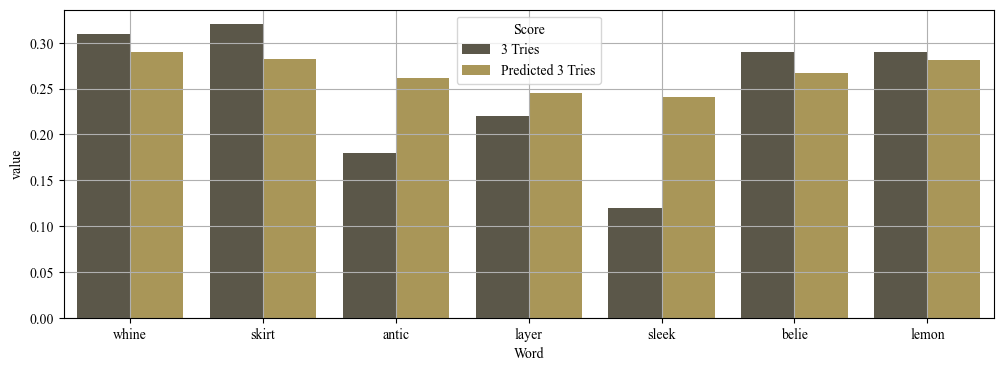

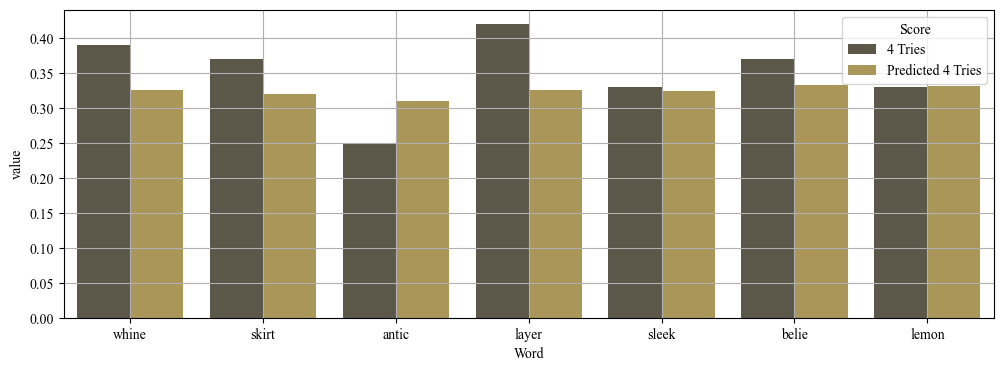

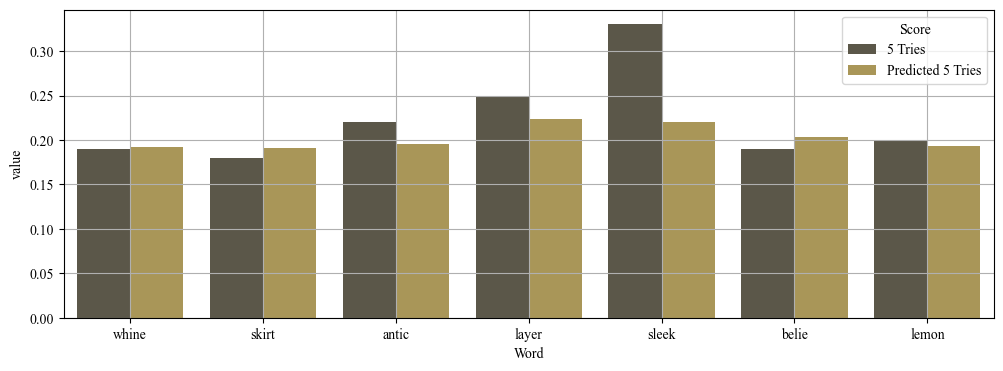

In [93]:
for i in ['3 Tries', '4 Tries', '5 Tries']:
    df4 = predictd[[i,'Predicted '+i]][:7]
    df4["Word"]=['whine',
     'skirt',
     'antic',
     'layer',
     'sleek',
     'belie',
     'lemon']
    df4=df4.reset_index()
    df4long = df4.melt(value_vars = [i,'Predicted '+i],
                       var_name="Score",value_name="value",id_vars="Word")
    plt.figure(figsize=(12,4))
    sns.barplot(data=df4long,x="Word", hue="Score",y="value",palette = ["#5E5946","#B69D4B","#2A86FF","#A4B7F0","#4B6DAB"])
    plt.grid()
    plt.savefig(i+"七日预测.svg")
    plt.show()

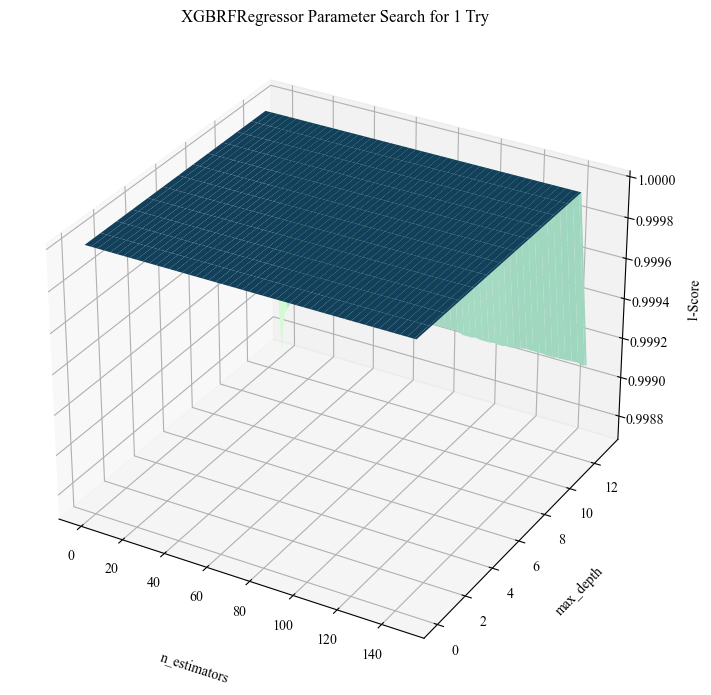

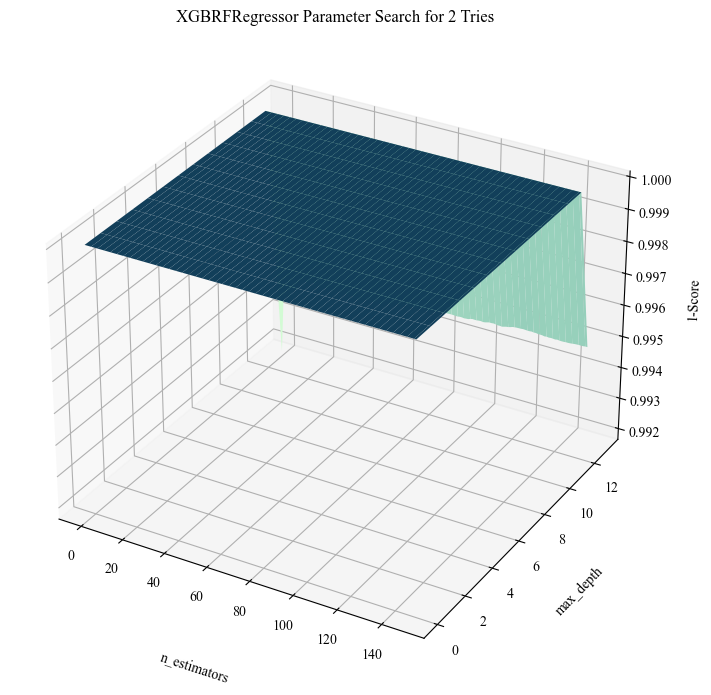

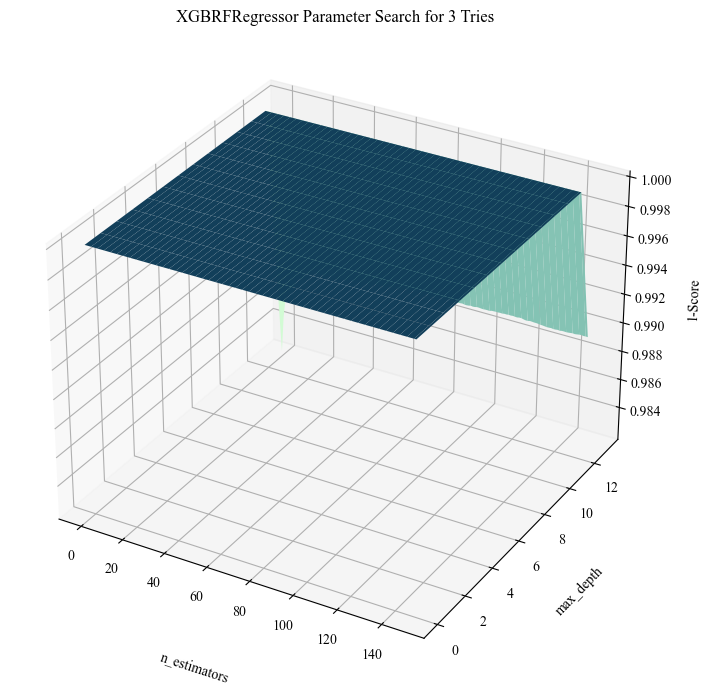

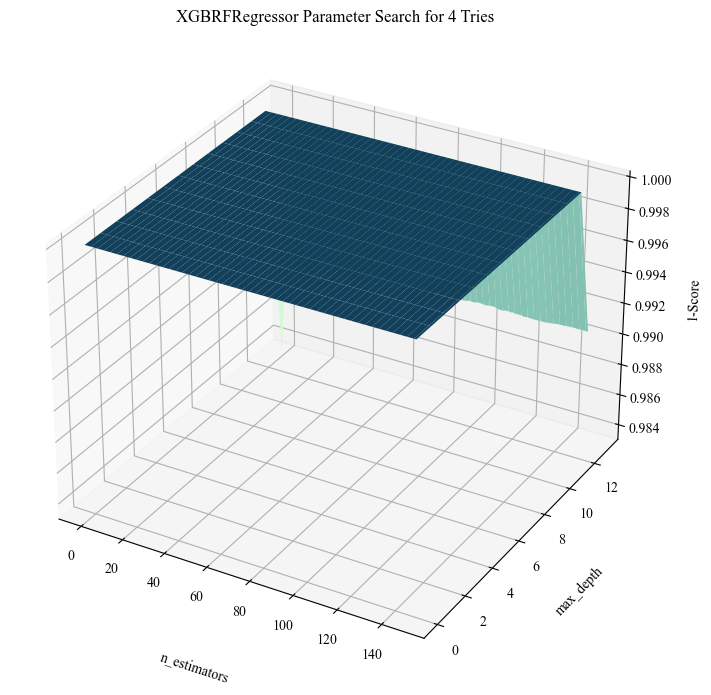

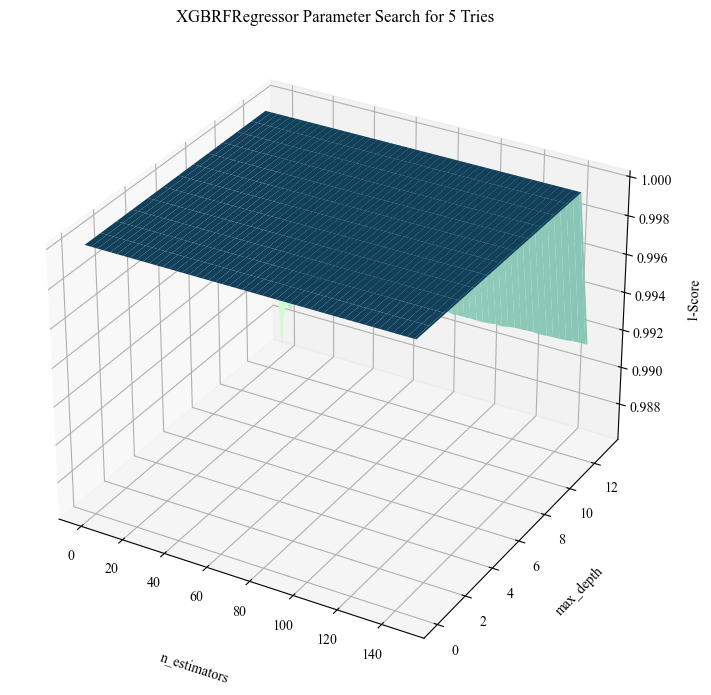

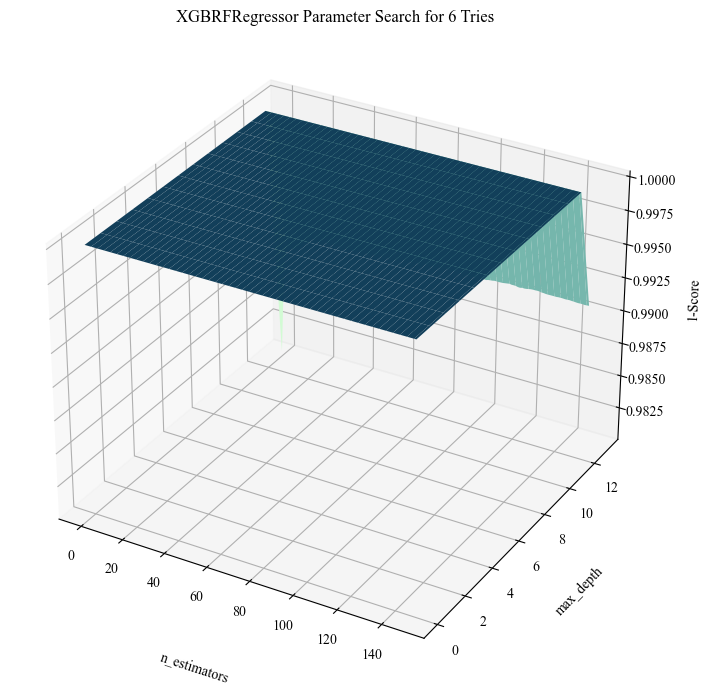

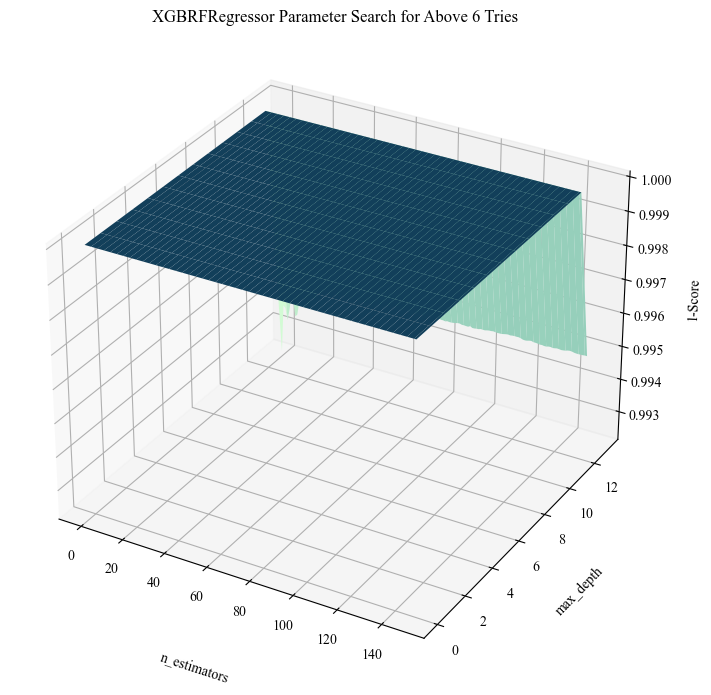

In [102]:
from palettable.cartocolors.sequential import DarkMint_4

for p in range(7):
    ## 使用3D曲面图可视化交叉验证的平均均方根误差
    n_estimators = np.arange(1, 150)
    max_depth = np.arange(1, 15)
    ## 数据准备
    i, j = np.meshgrid(range(len(n_estimators)), range(len(max_depth)))
    ## 可视化
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(111, projection="3d")
    surf = ax1.plot_surface(i, j, vmall[p], cmap=DarkMint_4.mpl_colormap

,
                            linewidth=0.1)
    # plt.xticks(range(len(n_estimators)/4),n_estimators,rotation=45)
    # plt.yticks(range(len(max_depth)),max_depth,rotation=125)
    ax1.set_xlabel("n_estimators", labelpad=25)
    ax1.set_ylabel("max_depth", labelpad=15)
    ax1.set_zlabel("1-Score", rotation=90, labelpad=10)
    plt.title("XGBRFRegressor Parameter Search for "+col[p])
    plt.tight_layout()
    plt.savefig(col[p]+"参数选择.svg")
    plt.show()